In [1]:
import xarray as xr
import rioxarray as xrio
import earthaccess
import boto3
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings
from IPython.display import display, Markdown
import numpy as np
from pathlib import Path
Path.cwd()

warnings.filterwarnings('ignore')
%matplotlib inline

/home/vince/miniconda3/envs/545/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import netCDF4

In [ ]:
import boto3
s3_client = boto3.client('s3')
response = s3_client.list_buckets()
for bucket in response['Buckets']:
    print(bucket['Name'])

In [4]:
if (boto3.client('s3').meta.region_name == 'us-west-2'):
    display(Markdown('### us-west-2 Region Check: &#x2705;'))
else:
    display(Markdown('### us-west-2 Region Check: &#10060;'))
    raise ValueError('Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S')

### us-west-2 Region Check: &#x2705;

In [5]:
# Authenticate using Earthdata Login prerequisite files
auth = earthaccess.login()

From GES-DISC web search (https://disc.gsfc.nasa.gov):

All data available from 1980 to Present

Need to Calculate PM2.5 from a formula

PM2.5 Hourly: C1276812830-GES_DISC, s3://gesdisc-cumulus-prod-protected/MERRA2/M2T1NXAER.5.12.4/

    - https://disc.gsfc.nasa.gov/datasets/M2T1NXAER_5.12.4/summary

PM2.5 Monthly : C1276812866-GES_DISC, s3://gesdisc-cumulus-prod-protected/MERRA2_MONTHLY/M2TMNXAER.5.12.4/

    - https://disc.gsfc.nasa.gov/datasets/M2TMNXAER_5.12.4/summary

PM2.5 Monthly (Hourly Average): C1276812869-GES_DISC, s3://gesdisc-cumulus-prod-protected/MERRA2_DIURNAL/M2TUNXAER.5.12.4/

    - https://disc.gsfc.nasa.gov/datasets/M2TUNXAER_5.12.4/summary

MERRA2_CNN_HAQAST bias corrected global hourly surface total PM2.5 mass concentration, V1 (MERRA2_CNN_HAQAST_PM25): C3094710982-GES_DISC, s3://gesdisc-cumulus-prod-protected/HAQAST/MERRA2_CNN_HAQAST_PM25.1/

    - https://disc.gsfc.nasa.gov/datasets/MERRA2_CNN_HAQAST_PM25_1/summary
    - 2000-01-01 to  2024-06-01

In [6]:
from datetime import datetime, timedelta

def get_sundays(start_date, end_date):
    """
    Return a list of Sundays within the given date interval.
    
    Parameters:
        start_date (str): The start date in "YYYY-MM-DD" format.
        end_date (str): The end date in "YYYY-MM-DD" format.
    
    Returns:
        list of str: List of Sundays in "YYYY-MM-DD" format.
    """
    # Convert start and end dates to datetime objects
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    
    # Find the first Sunday on or after the start date
    current = start + timedelta(days=(6 - start.weekday()) % 7)
    
    # Generate all Sundays within the interval
    sundays = []
    while current <= end:
        sundays.append(current.strftime("%Y-%m-%d"))
        current += timedelta(days=7)  # Move to the next Sunday
    
    return sundays

# Example usage
start_date = "2022-05-01"
end_date = "2022-10-30"
sundays = get_sundays(start_date, end_date)
print(sundays)

['2022-05-01', '2022-05-08', '2022-05-15', '2022-05-22', '2022-05-29', '2022-06-05', '2022-06-12', '2022-06-19', '2022-06-26', '2022-07-03', '2022-07-10', '2022-07-17', '2022-07-24', '2022-07-31', '2022-08-07', '2022-08-14', '2022-08-21', '2022-08-28', '2022-09-04', '2022-09-11', '2022-09-18', '2022-09-25', '2022-10-02', '2022-10-09', '2022-10-16', '2022-10-23', '2022-10-30']


In [7]:
Path.cwd() /'merra_data'

PosixPath('/home/vince/Documents/UM_591_Data/Project_4/merra_data')

In [9]:
# option 1: download files to disk
for sunday in sundays:
    # Search for the granule by DOI
    results = earthaccess.search_data(
    concept_id="C3094710982-GES_DISC", temporal=(sunday,sunday))
    files = earthaccess.download(results, Path.cwd() /'merra_data')

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
import os

# filter out unneeded files

def get_matching_files(folder_path, sundays):
    """
    Return a list of files in the folder that match the given list of Sunday dates.
    
    Parameters:
        folder_path (str): Path to the folder containing the files.
        sundays (list of str): List of Sundays in "YYYYMMDD" format to match.
        
    Returns:
        list of str: List of file paths matching the dates.
    """
    # Format Sundays in the "YYYYMMDD" format for matching
    sunday_strings = [date.replace("-", "") for date in sundays]
    
    # Get all files in the folder
    files = os.listdir(folder_path)
    
    # Filter files that contain a matching date
    matching_files = [
        os.path.join(folder_path, f)
        for f in files
        if any(date in f for date in sunday_strings)
    ]
    
    return matching_files

files = get_matching_files(Path.cwd() /'merra_data', sundays)
print(files)

['/home/vince/Documents/UM_591_Data/Project_4/merra_data/MERRA2_HAQAST_CNN_L4_V1.20221023.nc4', '/home/vince/Documents/UM_591_Data/Project_4/merra_data/MERRA2_HAQAST_CNN_L4_V1.20220605.nc4', '/home/vince/Documents/UM_591_Data/Project_4/merra_data/MERRA2_HAQAST_CNN_L4_V1.20220807.nc4', '/home/vince/Documents/UM_591_Data/Project_4/merra_data/MERRA2_HAQAST_CNN_L4_V1.20220911.nc4', '/home/vince/Documents/UM_591_Data/Project_4/merra_data/MERRA2_HAQAST_CNN_L4_V1.20221002.nc4', '/home/vince/Documents/UM_591_Data/Project_4/merra_data/MERRA2_HAQAST_CNN_L4_V1.20220522.nc4', '/home/vince/Documents/UM_591_Data/Project_4/merra_data/MERRA2_HAQAST_CNN_L4_V1.20220612.nc4', '/home/vince/Documents/UM_591_Data/Project_4/merra_data/MERRA2_HAQAST_CNN_L4_V1.20220821.nc4', '/home/vince/Documents/UM_591_Data/Project_4/merra_data/MERRA2_HAQAST_CNN_L4_V1.20220828.nc4', '/home/vince/Documents/UM_591_Data/Project_4/merra_data/MERRA2_HAQAST_CNN_L4_V1.20220724.nc4', '/home/vince/Documents/UM_591_Data/Project_4/merr

In [13]:
lon_min, lon_max = -140, -90
lat_min, lat_max = 35, 55

# a simple Albers Equal Area projection 
crs_proj4 = "+proj=aea +lat_1=42 +lat_2=48 +lat_0=45 +lon_0=-115 +datum=WGS84 +units=m +no_defs"

x_min, x_max = -1500000, 1500000
y_min, y_max = -750000, 1000000
resolution = 5000 # meters

# Ensure bounds are divisible by the resolution
x_range = x_max - x_min
y_range = y_max - y_min

x_steps = x_range // resolution
y_steps = y_range // resolution

# Corrected bounds
x_max = x_min + (x_steps * resolution)
y_max = y_min + (y_steps * resolution)

dst_bounds = (x_min, x_max, y_min, y_max)

In [14]:
from rasterio.enums import Resampling

def process_dataset(file):
    ds = xr.open_mfdataset(file, combine='by_coords', engine='netcdf4', decode_coords='all')
    ds = ds.rio.write_crs("EPSG:4326", inplace=True)
    
    ds = ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    ds_time_filtered = ds.sel(time=ds.time.dt.strftime('%H:%M:%S') == '12:30:00')

    # Filter spatial bounds
    ds_filtered = ds_time_filtered.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    ds_filtered = ds_filtered.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    
    ds_reprojected = ds_filtered.rio.reproject(
        crs_proj4,
        dst_bounds=dst_bounds,
        resolution=(resolution, resolution),
        resampling=Resampling.bilinear
    )       
    
    ds_reprojected = ds_reprojected.sel(x=slice(x_min, x_max), y=slice(y_max, y_min))
    ds_reprojected = ds_reprojected.rio.write_crs(crs_proj4, inplace=True)
    
    return ds_reprojected

In [15]:
datasets = [process_dataset(file) for file in files]

combined_ds = xr.concat(datasets, dim='time')

In [16]:
combined_ds


<xarray.Dataset> Size: 68MB
Dimensions:                  (time: 27, y: 350, x: 600)
Coordinates:
  * x                        (x) float64 5kB -1.497e+06 -1.492e+06 ... 1.498e+06
  * y                        (y) float64 3kB 9.959e+05 9.909e+05 ... -7.491e+05
  * time                     (time) datetime64[ns] 216B 2022-10-23T12:30:00 ....
    spatial_ref              int64 8B 0
Data variables:
    MERRA2_CNN_Surface_PM25  (time, y, x) float32 23MB 2.473 2.384 ... 5.312
    QFLAG                    (time, y, x) float64 45MB 2.0 2.0 2.0 ... 4.0 4.0
Attributes: (12/33)
    Comment:                           filename: MERRA2_HAQAST_CNN_L4_V1_2022...
    Filename:                          MERRA2_HAQAST_CNN_L4_V1_20221023.nc4
    Conventions:                       CF-1
    Institution:                       NASA Goddard Space Flight Center
    References:                        http://gmao.gsfc.nasa.gov ; https://do...
    Format:                            NetCDF-4/HDF-5
    ...                                ...
    RangeEndingDate:                   2022-10-23
    RangeEndingTime:                   23:59:59.000000
    DODS_EXTRA.Unlimited_Dimension:    time
    history:                           2023-04-21 04:24:38 GMT Hyrax-1.16.3 h...
    ProcessingLevel:                   4
    MapProjection:                     Geographic lat/lon. Datum: WGS-84

In [55]:
combined_ds.MERRA2_CNN_Surface_PM25[0]

<xarray.DataArray 'MERRA2_CNN_Surface_PM25' (y: 350, x: 600)> Size: 840kB
array([[2.473225  , 2.3843722 , 2.3144038 , ..., 0.        , 0.        ,
        0.        ],
       [2.4323792 , 2.3475983 , 2.2772088 , ..., 0.        , 0.        ,
        0.        ],
       [2.393014  , 2.3120801 , 2.2374437 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.3795661 , 0.3654223 , 0.35083017, ..., 5.5693603 , 5.673527  ,
        5.7763176 ],
       [0.3717559 , 0.35857984, 0.34495598, ..., 5.5110574 , 5.6122274 ,
        5.7120233 ],
       [0.36437324, 0.3521639 , 0.33950728, ..., 5.4540715 , 5.5522485 ,
        5.649053  ]], dtype=float32)
Coordinates:
  * x            (x) float64 5kB -1.497e+06 -1.492e+06 ... 1.493e+06 1.498e+06
  * y            (y) float64 3kB 9.959e+05 9.909e+05 ... -7.441e+05 -7.491e+05
    time         datetime64[ns] 8B 2022-10-23T12:30:00
    spatial_ref  int64 8B 0
Attributes:
    units:      ug m-3
    long_name:  Bias corrected surface total PM2.5 mass concentration

In [17]:
# Fire vector data
viirs = Path("viirs_data/DL_FIRE_J1V-C2_550835_040122_110122")
viirs.exists()

True

In [18]:
import geopandas as gpd

In [19]:
viirs_data = gpd.read_file(viirs, bbox=(lon_min,lat_min,lon_max,lat_max))
viirs_data = viirs_data.to_crs(crs_proj4)

In [25]:
ends = [datetime.utcfromtimestamp(time.astype('O') / 1e9) for time in combined_ds.time.values]
starts = [end - timedelta(weeks=2) for end in ends]
periods = [f for f in zip(starts, ends)]
print(periods)


[(datetime.datetime(2022, 10, 9, 12, 30), datetime.datetime(2022, 10, 23, 12, 30)), (datetime.datetime(2022, 5, 22, 12, 30), datetime.datetime(2022, 6, 5, 12, 30)), (datetime.datetime(2022, 7, 24, 12, 30), datetime.datetime(2022, 8, 7, 12, 30)), (datetime.datetime(2022, 8, 28, 12, 30), datetime.datetime(2022, 9, 11, 12, 30)), (datetime.datetime(2022, 9, 18, 12, 30), datetime.datetime(2022, 10, 2, 12, 30)), (datetime.datetime(2022, 5, 8, 12, 30), datetime.datetime(2022, 5, 22, 12, 30)), (datetime.datetime(2022, 5, 29, 12, 30), datetime.datetime(2022, 6, 12, 12, 30)), (datetime.datetime(2022, 8, 7, 12, 30), datetime.datetime(2022, 8, 21, 12, 30)), (datetime.datetime(2022, 8, 14, 12, 30), datetime.datetime(2022, 8, 28, 12, 30)), (datetime.datetime(2022, 7, 10, 12, 30), datetime.datetime(2022, 7, 24, 12, 30)), (datetime.datetime(2022, 4, 24, 12, 30), datetime.datetime(2022, 5, 8, 12, 30)), (datetime.datetime(2022, 5, 1, 12, 30), datetime.datetime(2022, 5, 15, 12, 30)), (datetime.datetime(2

In [42]:
bandwidth = 50000 # meters

# Compute the standard deviation in terms of grid cells
sigma = bandwidth / resolution

from scipy.signal import fftconvolve

def gaussian_kernel(sigma):
    """Creates an anisotropic Gaussian kernel."""
    # Define kernel sizes
    kernel_size = int(6 * sigma)
    x = np.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    y = np.linspace(-kernel_size // 2, kernel_size // 2, kernel_size)
    x, y = np.meshgrid(x, y)
    kernel = np.exp(-(x**2 / (2 * sigma**2) + y**2 / (2 * sigma**2)))
    return kernel

# Create the kernel
kernel = gaussian_kernel(sigma)

def create_fire_signal(start, end):
    filter = (viirs_data.ACQ_DATE.apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) >= start) & (viirs_data.ACQ_DATE.apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) < end)
    filtered_viirs = viirs_data[filter]
    weights = filtered_viirs['FRP'].values
    x = filtered_viirs.geometry.x.values
    y = filtered_viirs.geometry.y.values
    
    # First do the analysis without weighting by FRP, to verify the fire locations with the above plot
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=list(combined_ds.MERRA2_CNN_Surface_PM25.shape[1:3]), range=[[y_min, y_max], [x_min, x_max]], weights=weights)

    # flip y axis to match the image (required debugging to see I needed to do this)
    heatmap = np.flipud(heatmap)
    
    # Perform convolution
    smoothed_heatmap = fftconvolve(heatmap, kernel, mode='same')
    
    # Set values lower than zero to zero
    smoothed_heatmap[smoothed_heatmap < 0] = 0.0

    return smoothed_heatmap
    
heatmap = create_fire_signal(periods[0][0], periods[0][1])

In [102]:
# data structure for each of our our prediction pairs
from collections import namedtuple

Prediction = namedtuple("Prediction", "viirs merra2 date")

In [117]:
samples = {}

for start, end in periods:
    date_str = datetime.strftime(end, "%Y-%m-%d")
    viirs = create_fire_signal(start, end)
    merra2 = combined_ds.sel(time=end).MERRA2_CNN_Surface_PM25.values
    samples[date_str] = Prediction(viirs=viirs, merra2=merra2, date=date_str)

## Linear Regression

In [167]:
X = np.concatenate([samples[sample].viirs.flatten() for sample in samples])
y = np.concatenate([samples[sample].merra2.flatten() for sample in samples])

In [168]:
print(X.shape)
print(y.shape)

(5670000,)
(5670000,)


In [169]:
X = np.reshape(X, (len(X), 1))
y = np.reshape(y, (len(y), 1))

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)

In [171]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [172]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 28.948777105454212
R² Score: 0.08695549361120858


## Displaying the data

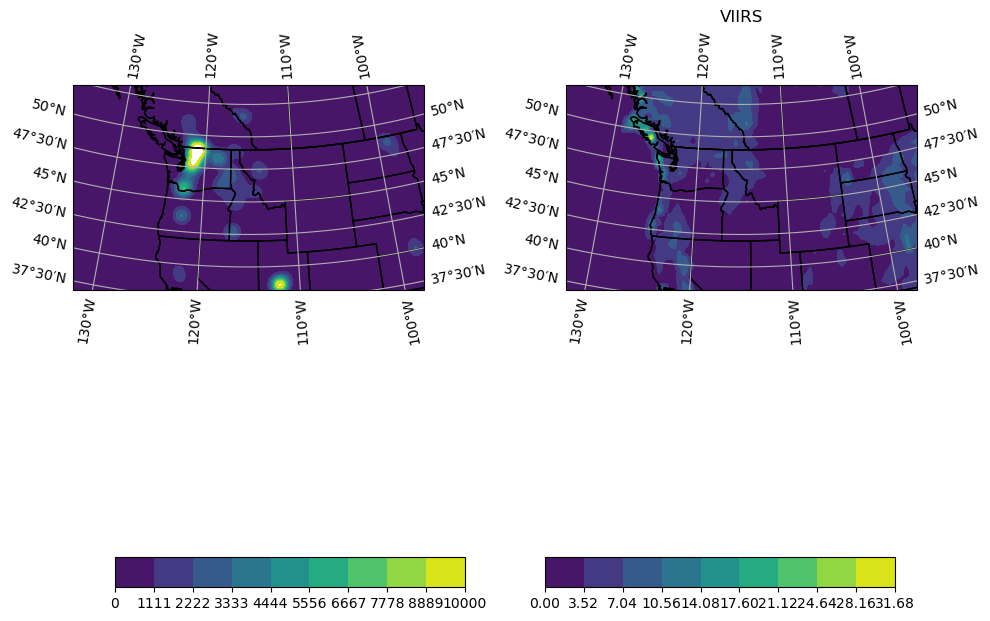

In [99]:
crs_proj4 = ccrs.AlbersEqualArea(
    central_longitude=-115,  # Central meridian
    central_latitude=45,     # Latitude of origin
    standard_parallels=(42, 48)  # Standard parallels
)

plt.rcParams['figure.figsize'] = 10,10

# Set up figure
fig = plt.figure()

ax = fig.add_subplot(121, projection=crs_proj4)
ax.set_extent([x_min, x_max, y_min, y_max], crs=crs_proj4) # CONUS extent
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

# Set up filled and line contours
filled_c1 = ax.contourf(combined_ds.x, combined_ds.y, heatmap, levels=np.linspace(0,10000,10), 
                       transform=crs_proj4)

# plot the MERRA2 data

heatmap_merra2 = combined_ds.sel(time=periods[0][1]).MERRA2_CNN_Surface_PM25.values

# Lat/lon grid lines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax2 = fig.add_subplot(122, projection=crs_proj4)
ax2.set_extent([x_min, x_max, y_min, y_max], crs=crs_proj4) # CONUS extent
ax2.coastlines(resolution='50m')
ax2.add_feature(cfeature.BORDERS)
ax2.add_feature(cfeature.STATES)

# Set up filled and line contours
# 10 levels from 0 to max
max_val = heatmap_merra2.max()
levels = np.linspace(0, max_val, 10)

filled_c2 = ax2.contourf(combined_ds.x, combined_ds.y, heatmap_merra2, levels=levels, 
                       transform=crs_proj4)

# Lat/lon grid lines
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#ax2.text(x=0.5, y = -.4, s = "testing", transform=ax2.transAxes, 
         #  ha='center', va='top', fontsize=10, fontweight="bold")
ax2.set_title("VIIRS")

# Set up colorbar and figure title
# Add individual colorbars beneath each subplot
cbar_ax1 = fig.add_axes([0.12, 0.1, 0.35, 0.03])  # [left, bottom, width, height] for first colorbar
cbar_ax2 = fig.add_axes([0.55, 0.1, 0.35, 0.03])  # [left, bottom, width, height] for second colorbar

fig.colorbar(filled_c1, cax=cbar_ax1, orientation='horizontal')  # Colorbar for first plot
fig.colorbar(filled_c2, cax=cbar_ax2, orientation='horizontal')  # Colorbar for second plot
#fig.suptitle('VIIRS Fire data 2DHist', fontsize=16, y = .67)

plt.tight_layout()

plt.show()